# HW5

1. validation data  를 따로 분리하여 overfitting  점검하고 해결하기
2.   시계열 출력층에 L1   규제화를 부여하고 lambda  값을 변화시켜 overfitting  관점에서 설명하기

# Stationary? 

In [117]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

from pandas_datareader.data import DataReader
from datetime import datetime

In [118]:
# 주식 시점 입력(시작/끝)
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

In [119]:
data= DataReader('GOOG', 'yahoo', start, end)   # 구글의 주식 데이터 가져옴

In [120]:
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-05-05,1373.939941,1337.459961,1337.920044,1351.109985,1651500,1351.109985
2020-05-06,1371.119995,1347.290039,1361.689941,1347.300049,1215400,1347.300049
2020-05-07,1377.599976,1355.270020,1365.939941,1372.560059,1397600,1372.560059
2020-05-08,1398.760010,1375.479980,1383.130005,1388.369995,1386900,1388.369995
2020-05-11,1416.530029,1377.151978,1378.280029,1403.260010,1412100,1403.260010


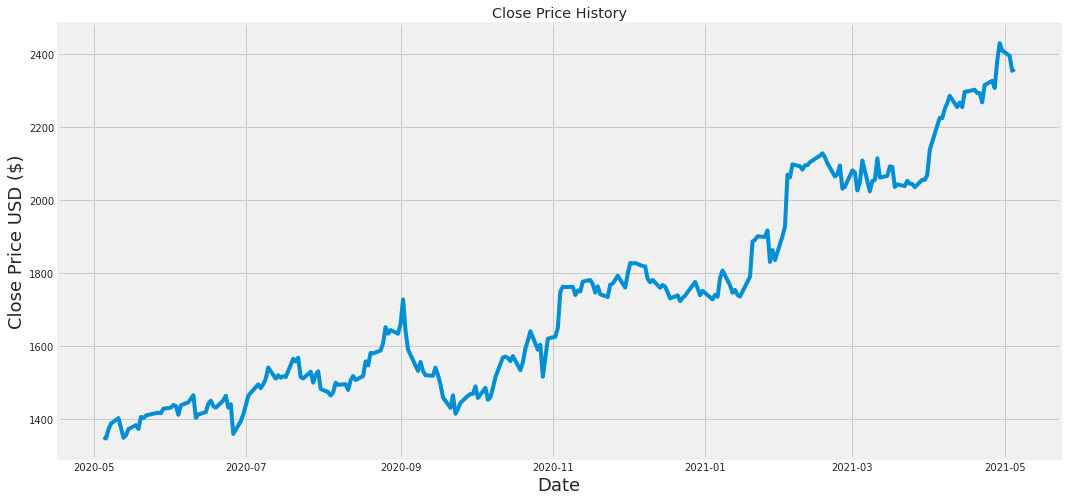

In [121]:
# 종가 시각화
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(data['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

증가 추세를 벗어나면 일정 시간동안 추세를 벗어나있다가 느리게 전반적인 추세로 돌아오므로,       
비정상성을 가지는 데이터임을 추측 가능

In [122]:
data.describe()   # max와 min의 차이가 많이나는 상황

,High,Low,Open,Close,Volume,Adj Close
count,253.000000,253.000000,253.000000,253.000000,2.530000e+02,253.000000
mean,1751.659018,1712.527495,1730.181441,1732.520331,1.652827e+06,1732.520331
std,288.541514,285.625520,286.702364,287.053432,5.924438e+05,287.053432
min,1357.420044,1323.910034,1335.020020,1347.300049,1.717010e+05,1347.300049
25%,1506.589966,1473.079956,1490.000000,1494.489990,1.289300e+06,1494.489990
50%,1709.713989,1632.219971,1673.775024,1660.709961,1.535100e+06,1660.709961
75%,2050.989990,2002.020020,2023.369995,2024.170044,1.828400e+06,2024.170044
max,2452.377930,2402.280029,2410.330078,2429.889893,4.329100e+06,2429.889893


In [123]:
## Dickey-Fuller의 단위근 검정
from statsmodels.tsa.stattools import adfuller  # augmented 디큐플러 테스트
result=adfuller(data['Close'])  # null은 단위근이 있다 = 이 데이터는 nonstaionary하다 
print('검정통계량 : ', result[0])
print('P-value : ', result[1])

검정통계량 :  0.26129409407405846
P-value :  0.9754973043815989


P-value가 매우 크므로 귀무가설을 기각하지 못한다. 비정상성을 지니는 데이터이다. 

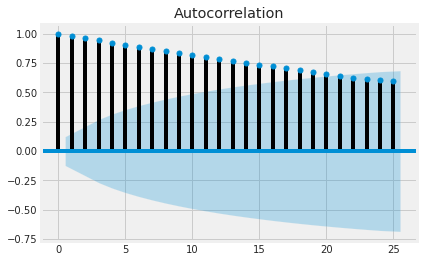

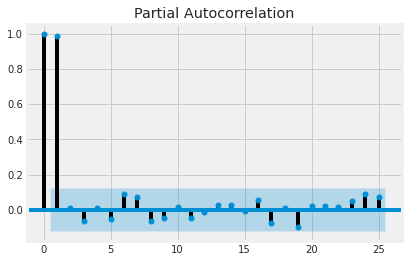

In [124]:
# 자기상관함수, 편자기상관함수
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data['Close'])
plot_pacf(data['Close'])
plt.show()  # 지수 감소형태를 띔

자기상관함수가 선형적으로 매우 느리게 감소하는 모습. 따라서 일일 종가는 비정상시계열이므로 차분이 필요함. 

             High         Low        Open       Close      Volume   Adj Close
count  252.000000  252.000000  252.000000  252.000000  252.000000  252.000000
mean     0.002172    0.002248    0.002266    0.002211   -0.008983    0.002211
std      0.016308    0.015902    0.018483    0.017758    0.374898    0.017758
min     -0.050647   -0.049079   -0.057493   -0.058155   -2.324356   -0.058155
25%     -0.006830   -0.006803   -0.007545   -0.006261   -0.199760   -0.006261
50%      0.001169    0.003111    0.001763    0.003054   -0.012588    0.003054
75%      0.009977    0.011488    0.012459    0.012282    0.184825    0.012282
max      0.078985    0.053832    0.093825    0.071353    1.390467    0.071353


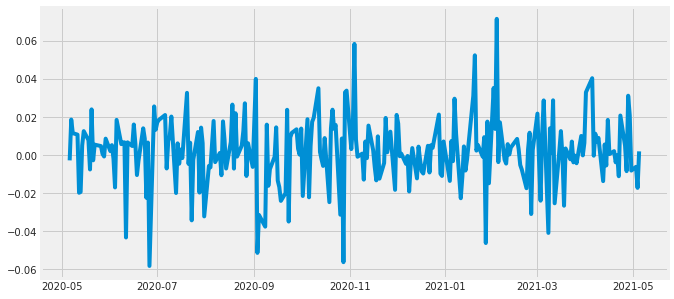

In [125]:
## 로그수익률로 변화 (차분작업)
datapct=data.pct_change()
logreturn=np.log(1+datapct)  # 차분의 역할
logreturn.head()
print(logreturn.describe())  # log return 으로 바꿈
plt.figure(figsize=(10,5))
plt.plot(logreturn['Close'])
plt.show()  # 0을 중심으로 매우 왔다갔다하므로 stationary

로그 수익률 전환 결과 0을 중심으로 왔다갔다하므로 정상시계열일 가능성이 높음

In [126]:
from statsmodels.tsa.stattools import adfuller  ## 차분 후 디큐플러테스트 적용
logreturn=logreturn.dropna()  ## 차분을 취했기에 missing이 발생 > drop 해주기!
result=adfuller(logreturn['Close'])
print('검정통계량 : ', result[0])
print('P-value : ', result[1])

검정통계량 :  -16.902822779433205
P-value :  1.0245957068819297e-29


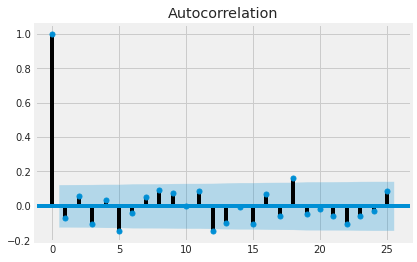

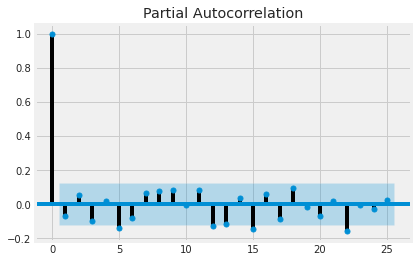

<class 'pandas.core.frame.DataFrame'>


In [127]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(logreturn['Close'])
plot_pacf(logreturn['Close'])
plt.show()
print(type(logreturn))

일일 종가 로그수익률의 acf와 pacf는 모두 절단형태를 띄는 모습 !    
p는 우선 14로 설정

## Split

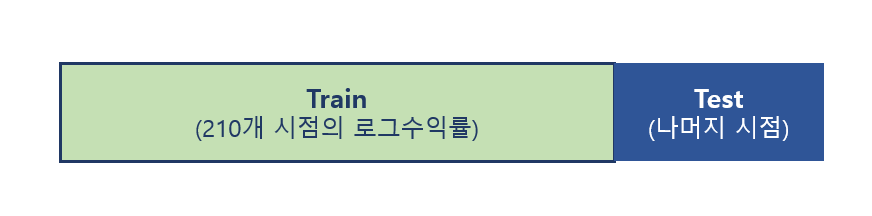

In [128]:
# split 
logr1=logreturn['Close'].values  # 로그수익률
print(logr1.shape)  

logr=logr1.reshape(1,-1)
print(logr.shape)

inte=14    # p값

x=[]
y=[]
for i in range(logr.shape[1]):
    if i+inte>logr.shape[1]-1:
        break
    else:
         xx=logr[0,i:i+inte]
         x.append(xx)
         yy=logr[0,i+inte]
         y.append(yy)

x=np.asarray(x)
y=np.asarray(y)
print(x.shape)
print(y.shape)

(252,)
(1, 252)
(238, 14)
(238,)


In [129]:
# 첫 210개 시점의 로그수익률을 train. 나머지 16개 시점을 test
xx=x[:210]
x_test=x[210:]
yy=y[:210]
y_test=y[210:]

In [130]:
# valid split
xx.shape

(210, 14)

In [131]:
pd.DataFrame(xx)   # train data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.002824,0.018575,0.011453,0.010668,-0.019806,-0.019384,0.005027,0.012501,0.007798,-0.007583,0.023909,-0.002790,0.005417,0.004669
1,0.018575,0.011453,0.010668,-0.019806,-0.019384,0.005027,0.012501,0.007798,-0.007583,0.023909,-0.002790,0.005417,0.004669,0.000578
2,0.011453,0.010668,-0.019806,-0.019384,0.005027,0.012501,0.007798,-0.007583,0.023909,-0.002790,0.005417,0.004669,0.000578,-0.000783
3,0.010668,-0.019806,-0.019384,0.005027,0.012501,0.007798,-0.007583,0.023909,-0.002790,0.005417,0.004669,0.000578,-0.000783,0.008568
4,-0.019806,-0.019384,0.005027,0.012501,0.007798,-0.007583,0.023909,-0.002790,0.005417,0.004669,0.000578,-0.000783,0.008568,0.002027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,0.021684,-0.002728,-0.023952,0.010982,0.028600,-0.040836,0.013996,0.001134,0.028656,-0.025309,0.002214,0.012518,-0.000688,-0.026586
206,-0.002728,-0.023952,0.010982,0.028600,-0.040836,0.013996,0.001134,0.028656,-0.025309,0.002214,0.012518,-0.000688,-0.026586,0.003422
207,-0.023952,0.010982,0.028600,-0.040836,0.013996,0.001134,0.028656,-0.025309,0.002214,0.012518,-0.000688,-0.026586,0.003422,-0.002259
208,0.010982,0.028600,-0.040836,0.013996,0.001134,0.028656,-0.025309,0.002214,0.012518,-0.000688,-0.026586,0.003422,-0.002259,0.007024


In [132]:
## train의 일부분을 valid로 나눔 (70:30으로)
x_train=xx[:147]
x_valid=xx[147:]
y_train=yy[:147]
y_valid=yy[147:]

In [133]:
print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape)   # valid 구성 완료

(147, 14) (63, 14) (147,) (63,)


# Modeling

## AR + Dense

원래 모델

In [134]:
# 원래 모델 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,GRU,LSTM
model=Sequential()
model.add(Dense(32,activation='relu',input_shape=(14,)))
model.add(Dense(1))                
model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 32)                480       
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 33        
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


In [135]:
model.compile(optimizer='rmsprop', loss='mse',metrics=['mae'])
history = model.fit(x_train,y_train,epochs=30,batch_size=32,  validation_data=(x_valid, y_valid))

Epoch 1/30
5/5 [==============================] - 1s 43ms/step - loss: 4.0851e-04 - mae: 0.0154 - val_loss: 4.2815e-04 - val_mae: 0.0151
Epoch 2/30
5/5 [==============================] - 0s 12ms/step - loss: 3.4299e-04 - mae: 0.0136 - val_loss: 4.2751e-04 - val_mae: 0.0151
Epoch 3/30
5/5 [==============================] - 0s 11ms/step - loss: 3.0873e-04 - mae: 0.0132 - val_loss: 4.2314e-04 - val_mae: 0.0151
Epoch 4/30
5/5 [==============================] - 0s 11ms/step - loss: 2.7786e-04 - mae: 0.0120 - val_loss: 4.3143e-04 - val_mae: 0.0153
Epoch 5/30
5/5 [==============================] - 0s 11ms/step - loss: 2.7992e-04 - mae: 0.0128 - val_loss: 4.1226e-04 - val_mae: 0.0148
Epoch 6/30
5/5 [==============================] - 0s 11ms/step - loss: 2.8025e-04 - mae: 0.0126 - val_loss: 4.1994e-04 - val_mae: 0.0149
Epoch 7/30
5/5 [==============================] - 0s 12ms/step - loss: 2.4862e-04 - mae: 0.0118 - val_loss: 4.2561e-04 - val_mae: 0.0150
Epoch 8/30
5/5 [=========================

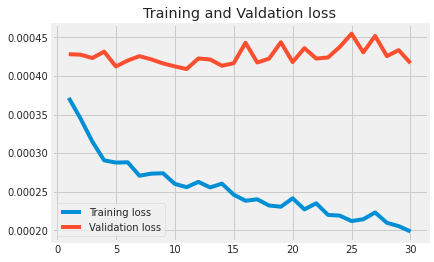

In [136]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Valdation loss')
plt.legend()
plt.show()  

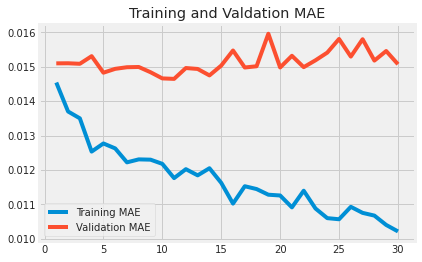

In [137]:
# mae
loss = history.history['mae']
val_loss = history.history['val_mae']
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, label='Training MAE')
plt.plot(epochs, val_loss, label='Validation MAE')
plt.title('Training and Valdation MAE')
plt.legend()
plt.show()  

바꾼 모델 

In [138]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,GRU,LSTM, Dropout
model=Sequential()
model.add(Dense(32,activation='relu',kernel_initializer='he_normal', input_shape=(14,)))
model.add(Dropout(0.5))
model.add(Dense(1, kernel_regularizer=tf.keras.regularizers.L1(0.01)))                
model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 32)                480       
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 33        
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


In [139]:
model.compile(optimizer='rmsprop', loss='mse',metrics=['mae'])
history = model.fit(x_train,y_train,epochs=30,batch_size=32,  validation_data=(x_valid, y_valid))

Epoch 1/30
5/5 [==============================] - 1s 47ms/step - loss: 0.0634 - mae: 0.0281 - val_loss: 0.0605 - val_mae: 0.0214
Epoch 2/30
5/5 [==============================] - 0s 12ms/step - loss: 0.0602 - mae: 0.0221 - val_loss: 0.0582 - val_mae: 0.0199
Epoch 3/30
5/5 [==============================] - 0s 11ms/step - loss: 0.0579 - mae: 0.0212 - val_loss: 0.0563 - val_mae: 0.0190
Epoch 4/30
5/5 [==============================] - 0s 11ms/step - loss: 0.0561 - mae: 0.0212 - val_loss: 0.0546 - val_mae: 0.0181
Epoch 5/30
5/5 [==============================] - 0s 11ms/step - loss: 0.0544 - mae: 0.0198 - val_loss: 0.0529 - val_mae: 0.0174
Epoch 6/30
5/5 [==============================] - 0s 11ms/step - loss: 0.0526 - mae: 0.0181 - val_loss: 0.0513 - val_mae: 0.0171
Epoch 7/30
5/5 [==============================] - 0s 11ms/step - loss: 0.0512 - mae: 0.0188 - val_loss: 0.0498 - val_mae: 0.0167
Epoch 8/30
5/5 [==============================] - 0s 11ms/step - loss: 0.0495 - mae: 0.0172 - val

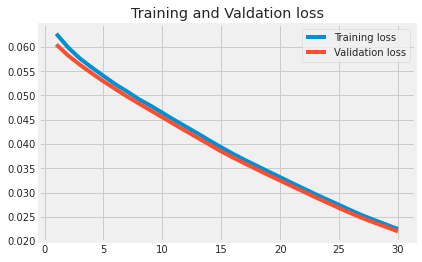

In [140]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Valdation loss')
plt.legend()
plt.show()  

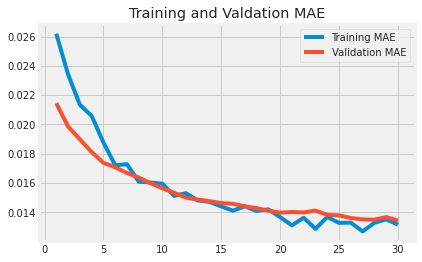

In [141]:
# mae
loss = history.history['mae']
val_loss = history.history['val_mae']
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, label='Training MAE')
plt.plot(epochs, val_loss, label='Validation MAE')
plt.title('Training and Valdation MAE')
plt.legend()
plt.show()  

In [142]:
# evaluate
loss_acc=model.evaluate(x_train,y_train)
loss_valid=model.evaluate(x_valid,y_valid)
los_test=model.evaluate(x_test,y_test)
print(loss_acc)
print(loss_valid)
print(los_test)

1/1 [==============================] - 0s 17ms/step - loss: 0.0218 - mae: 0.0107
[0.021922871470451355, 0.01300086546689272]
[0.021997565403580666, 0.013430379331111908]
[0.021837500855326653, 0.010728172026574612]


### L1 규제화 lambda값 변화시키기

Epoch 1/30
5/5 [==============================] - 1s 49ms/step - loss: 8.3307e-04 - mae: 0.0235 - val_loss: 5.1027e-04 - val_mae: 0.0172
Epoch 2/30
5/5 [==============================] - 0s 12ms/step - loss: 6.9245e-04 - mae: 0.0206 - val_loss: 4.9820e-04 - val_mae: 0.0169
Epoch 3/30
5/5 [==============================] - 0s 12ms/step - loss: 6.2983e-04 - mae: 0.0197 - val_loss: 4.6738e-04 - val_mae: 0.0165
Epoch 4/30
5/5 [==============================] - 0s 12ms/step - loss: 5.6988e-04 - mae: 0.0192 - val_loss: 4.4726e-04 - val_mae: 0.0160
Epoch 5/30
5/5 [==============================] - 0s 12ms/step - loss: 7.0241e-04 - mae: 0.0191 - val_loss: 4.3220e-04 - val_mae: 0.0158
Epoch 6/30
5/5 [==============================] - 0s 12ms/step - loss: 5.6399e-04 - mae: 0.0173 - val_loss: 4.3763e-04 - val_mae: 0.0156
Epoch 7/30
5/5 [==============================] - 0s 12ms/step - loss: 4.9631e-04 - mae: 0.0163 - val_loss: 4.2581e-04 - val_mae: 0.0154
Epoch 8/30
5/5 [=========================

[]

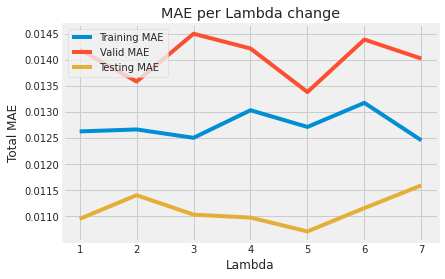

In [155]:
lambda_list = [0.0000000001, 0.0000001, 0.0001, 0.001, 0.01, 0.3, 0.8 ]

train_errors = []
valid_errors = []
test_errors = [] 

for i in lambda_list:
  model=Sequential()
  model.add(Dense(32,activation='relu',kernel_initializer='he_normal', input_shape=(14,)))
  model.add(Dropout(0.5))
  model.add(Dense(1, kernel_regularizer=tf.keras.regularizers.L1(i)))                
  model.compile(optimizer='rmsprop', loss='mse',metrics=['mae'])
  model.fit(x_train,y_train,epochs=30,batch_size=32,  validation_data=(x_valid, y_valid))
  train_errors.append(model.evaluate(x_train,y_train)[1])
  valid_errors.append(model.evaluate(x_valid,y_valid)[1])
  test_errors.append(model.evaluate(x_test,y_test)[1])

x = np.arange(len(lambda_list)) + 1
plt.plot(x, train_errors, label='Training MAE') 
plt.plot(x, valid_errors, label='Valid MAE') 
plt.plot(x, test_errors, label='Testing MAE') 
plt.xlabel('Lambda')
plt.ylabel('Total MAE')
plt.legend()
plt.title('MAE per Lambda change')
plt.plot() 